In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import math
import tensorflow as tf
import pandas as pd
import pickle

### Load Dataset

In [2]:
epochs = 30
size = 75
ReqLabels = [0,1,2,3,4,5,6,7,8,14,17,18,19,20,22,23,26,33,34,35,36,37,38,39]

Train_Path = 'D:/Data/Traffic Signs/Train.csv'
Test_Path = 'D:/Data/Traffic Signs/Test.csv'
Meta_Path = 'D:/Data/Traffic Signs/Meta.csv'
Labels_Path = 'D:/Data/Traffic Signs/Labels.csv'

Labels = []
labelData = pd.read_csv(Labels_Path)
for i,j in zip(labelData['ClassId'] , labelData['SignName']) :
    if i in ReqLabels :
        Labels.append(j)
        
print(Labels)

['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'Stop', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Bumpy road', 'Slippery road', 'Traffic signals', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left']


In [3]:
data = pd.read_csv(Meta_Path)
NoOfLabels = len(data['Path'])
print(NoOfLabels)

43


In [4]:
Count_Labels = {}
for i in ReqLabels :
    Count_Labels[i] = 0

Count_Labels

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 14: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 22: 0,
 23: 0,
 26: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0}

In [5]:
def LoadData(Dir,typeLoad) :
    data = pd.read_csv(Dir)
    display(data.head())
    X , Y = [] , []
    for i,rx1,ry1,rx2,ry2,cId in zip(data['Path'],data['Roi.X1'],data['Roi.Y1'],data['Roi.X2'],data['Roi.Y2'],data['ClassId']) :
        print(f'\r{len(X)}',end="")
        if cId in ReqLabels :
            i = 'D:/Data/Traffic Signs/' + i
            img = cv2.imread(i)
            img = img[ry1:ry2,rx1:rx2]
            img = cv2.resize(img,(size,size))
#             data = img_to_array(img)

#             samples = expand_dims(data, 0)

#             datagen = ImageDataGenerator(zoom_range=[0.5,1.0])

#             it = datagen.flow(samples, batch_size=1)

#             for i in range(3):
#                 batch = it.next()
#                 image = batch[0].astype('uint8')
            X.append(img)
            Y.append(ReqLabels.index(cId))
            if typeLoad == 'Train' :
                Count_Labels[cId] += 1
        
    return np.array(X)/255. , np.array(Y)

In [6]:
X_train , Y_train = LoadData(Train_Path,'Train')

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


23639

In [7]:
Count_Labels

{0: 210,
 1: 2220,
 2: 2250,
 3: 1410,
 4: 1980,
 5: 1860,
 6: 420,
 7: 1440,
 8: 1410,
 14: 780,
 17: 1110,
 18: 1200,
 19: 210,
 20: 360,
 22: 390,
 23: 510,
 26: 600,
 33: 689,
 34: 420,
 35: 1200,
 36: 390,
 37: 210,
 38: 2070,
 39: 300}

In [8]:
X_test , Y_test = LoadData(Test_Path,'Test')

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


7620

In [9]:
print(f'X_train shape : {X_train.shape}, Y_train shape : {Y_train.shape}')
print(f'X_test shape : {X_test.shape}, Y_test shape : {Y_test.shape}')

X_train shape : (23639, 75, 75, 3), Y_train shape : (23639,)
X_test shape : (7620, 75, 75, 3), Y_test shape : (7620,)


In [10]:
fileName = 'Model.obj'
def callback(obj,fileName) :
    print('CallBack : ',fileName,'Updated')
    f = open(fileName, 'wb') 
    pickle.dump(obj, f)

### Activations

In [11]:
class ReLU :
    def __init__ (self) :
        self.__type__ = 'activation'
        self.__Name__ = 'ReLU'
    
    def feed(self,X) :
        self.input = X
        self.input_shape=X.shape
        self.output = np.maximum(0,X)
        self.output_shape = self.input_shape
        return self.output
    
    def feed_back(self,Z,grad_output,lr) :
        grad = Z > 0
        #print(grad.shape,grad_output.shape)
        return grad_output*grad
    
class Softmax :
    def __init__ (self) :
        self.__type__ = 'activation'
        self.__Name__ = 'Softmax'
    
    def feed(self,X) :
        self.input = X
        e_x = np.exp(X-np.max(X))
        self.output = e_x/e_x.sum()
        return self.output
    
    def grad_feed(self,X) :
        e_x = np.exp(X)
        return (e_x/e_x.sum()) - (e_x**2/(e_x.sum()**2))
    
    def feed_back(self,Z,grad_output,lr) :
        e_x = np.exp(Z)
        out = e_x/ex.sum()
        grad = out*(1-out)
        #grad = e_x/e_x.sum()**2 - (e_x**2/(e_x.sum()**2))
        return grad_output*grad
    
class Sigmoid :
    def __init__ (self) :
        self.__type__ = 'activation'
        self.__Name__ = 'Sigmoid'
    
    def feed(self,X) :
        self.input = X
        self.output = 1/(1+np.exp(-X))
        return self.output
    
    def feed_back(self,Z,grad_output,lr) :
        out = 1/(1+np.exp(-Z))
        grad = out*((1-out)**2)
        return grad_output*grad

## Layers

`Convolution` Layer

`MaxPooling` Layer

`Average Pooling` Layer

### `Flatten` Layer

In [12]:
class Flatten :
    
    def __init__ (self,input_shape=None,output_shape=None,__Name__='Flatten') :
        self.__Name__ = __Name__
        self.__type__ = 'flat'
        self.input_shape = input_shape
        self.A_F = None
        re = 1
        if output_shape is None :
            for i in input_shape :
                re *= i
            self.output_shape = re
        else :
            self.output_shape = output_shape
        
    def feed(self,X) :
        self.input = X
        self.output = X.ravel()
        return self.output
    
    def Summary(self) :
        l = len(self.__Name__)
        print(f'{self.__Name__}',' '*(20-l),self.input_shape,' '*(20-len(str(self.input_shape))),self.output_shape)

### `Dense` Layer

In [13]:
class Dense :
    
    def __init__ (self,input_shape,N_F,A_F=None,wt=None,bias=None,output_shape=None,__Name__='Dense') :
        self.__Name__ = __Name__
        self.__type__ = 'dense'
        self.input_shape = input_shape
        self.N_F = N_F
        self.A_F = A_F
        if output_shape is None :
            self.output_shape = N_F
        else :
            self.output_shape = output_shape
        if wt is None :
            self.weights = 0.5*np.random.randn(self.input_shape, self.output_shape) / np.sqrt(self.input_shape + self.output_shape)
        else :
            self.weights = wt
        if bias is None :
            self.bias = np.random.randn(1, self.output_shape) / np.sqrt(self.input_shape + self.output_shape)
        else :
            self.bias = bias
        
    def feed(self,X) :
        if X.shape[0] != 1 :
            output = []
            output.append(X)
            self.input = np.array(output)
        else :
            self.input = X
        self.output = np.dot(X,self.weights) + self.bias
        return self.output
    
    def feed_back(self, Z , output_error, learning_rate=1e-03):
        input_error = np.dot(output_error, self.weights.T)
        #output_error = output_error.mean(axis=0)*Z.T.shape[0]
        weights_error = np.dot(Z.T, output_error)
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error
    
#     def backward(self,grad_output,lr):
#         grad_input = np.dot(grad_output, self.weights.T)
#         grad_weights = np.dot(self.input.T, grad_output)
#         grad_biases = grad_output.mean(axis=0)*input.shape[0]
#         assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
#         self.weights = self.weights - self.learning_rate * grad_weights
#         self.biases = self.biases - self.learning_rate * grad_biases
#         return grad_input
    
    def Summary(self) :
        l = len(self.__Name__)
        print(f'{self.__Name__}',' '*(20-l),self.input_shape,' '*(20-len(str(self.input_shape))),self.output_shape)

In [14]:
class Sequential :
    
    def __init__ (self) :
        self.Layers = []
        self.input_shape = None
        self.Activations = []
        self.acc = []
        self.val_acc = []
        self.error = []
        self.val_error = []
        self.id = 1
        
    def add(self,Layer) :
        boo = False
        for layer in self.Layers :
            if Layer.__type__ == layer.__type__ :
                boo = True
                if '_' not in Layer.__Name__ :
                    Layer.__Name__ += '_'+str(self.id)
                name,k = Layer.__Name__.split('_')
                Layer.__Name__ = name+'_'+str(int(k)+1)
        if not boo :
            if '_' not in Layer.__Name__ :
                Layer.__Name__ += '_'+str(self.id)
        
        self.Layers.append(Layer)
        if Layer.__type__ != 'activation' :
            if self.input_shape is None :
                self.input_shape = Layer.input_shape
            self.output_shape = Layer.output_shape
        if Layer.A_F is not None :
            if Layer.A_F.lower() == 'softmax' :
                self.Activations.append(Softmax())
            elif Layer.A_F.lower() == 'sigmoid' :
                self.Activations.append(Sigmoid())
            else :
                self.Activations.append(ReLU())
        else :
            self.Activations.append(None)
        
    def compile(self,loss='cross_entropy',metrics=['acc']) :
        self.loss = loss
        self.metrics = metrics
        
    def one_hot_encode(self,labels) :
        Labels = np.zeros((len(labels),len(set(labels))))
        for i,label in enumerate(labels) :
            Labels[i][label] = 1
        return Labels
        
    def fit(self,train_data,valid_data=None,validation_split=.1,epochs=10,lr=0.01) :
        self.epochs = epochs
        if train_data is None :
            raise ValueError('Training Data Required')
        else :
            self.input = train_data[0]
            #self.Total = self.one_hot_encode(train_data[1])
            self.Total = train_data[1]
            self.target = self.Total
            self.No_of_outs = len(set(self.target))
        N = len(self.input)
        
        if valid_data is None :
            if validation_split != 0 :
                n = int(len(self.input)*(1-validation_split))
                K = np.random.randint(0,N,(N))
                for i in range(N-1) :
                    train_data[0][K[i]] = train_data[0][K[i+1]]
                    train_data[1][K[i]] = train_data[1][K[i+1]]
                self.input , self.target = train_data[0][:n] , self.Total[:n]
                self.val_input , self.val_target = train_data[0][n:] , self.Total[n:]
        else :
            self.val_input , self.val_target = valid_data[0] , valid_data[1]
        
        print('\nModel Fitting\n')
        
        for ep in range(epochs) :
            error = 0
            acc = 0
            
            print(f'\nepoch : {ep+1}/{epochs}')
            
            for c,(X,Y) in enumerate(zip(self.input,self.target)) :
                
                L_INPUTS , L_OUTPUTS ,  A_INPUTS , A_OUTPUTS = [] , [] , [] , []
                
                output = X
                loss = None
                out_err = None
                
                """
                    Forward Feeding [ Z = W*X + B ]
                """
                for layer , activation in zip(self.Layers,self.Activations) :
                    L_INPUTS.append(output)
                    output = layer.feed(output) # Feeding to Layer
                    L_OUTPUTS.append(output)
                    if activation is not None :
                        A_INPUTS.append(output)
                        output = activation.feed(output) # applying activation to output of the Layers
                        A_OUTPUTS.append(output)
                        
                activation_output = self.Activations[-1].output # a-l
                output = self.Layers[-1].output # z-l

                """
                    Loss Calculation or Output Error
                """
                
                if self.loss == 'cross_entropy' :
                    loss = self.crossentropy(activation_output,Y)
                    if math.isnan(loss) :
                        return None
                    grad_activation = self.Activations[-1].grad_feed(output)
                    out_err = self.grad_crossentropy(output,Y)*grad_activation
                
                """
                    Backward Feeding
                """
                
                try :
                
                    for i in range(1,len(self.Layers)-1) :
                        if self.Layers[-i].__Name__[0] != 'F' :
                            #print(self.Layers[-i].__Name__)
                            if self.Activations[-i].__Name__ != 'Softmax' :
                                out_err = self.Activations[-i].feed_back(A_INPUTS[-i],out_err,lr)
                                #print(self.Activations[-i].__Name__)
                            out_err = self.Layers[-i].feed_back(L_INPUTS[-i],out_err,lr)
                        else :
                            break
                            
                except :
                    pass
                
                error = np.mean(loss)
                print('\rerror=%f' % (error),end="")
                
            """
                Accuracy measuring at every epoch
            """
            
            accuracy = sum([y == np.argmax(model.predict(x)) for x, y in zip(self.input, self.target)]) / len(self.input)
            self.acc.append(accuracy)
            
            if 'acc' in self.metrics :
                val_accuracy = sum([y == np.argmax(model.predict(x)) for x, y in zip(self.val_input, self.val_target)]) / len(self.val_input)
                self.val_acc.append(val_accuracy)
                print(' acc=%f , val_acc=%f' % (accuracy , val_accuracy))
            else :
                print('\racc=%f' % (accuracy))
                
            callback(model,fileName)
            
        return None
            
    def mse(self,y_true, y_pred):
        return np.mean(np.power(y_true - y_pred, 2))
    
    def mse_prime(self,y_true, y_pred):
        return 2 * (y_pred - y_true) / y_pred.size
    
    def transfer_derivative(self,output):
        return output * (1.0 - output)
    
#     def crossentropy(self,pred,Truth) :
#         GroundTruth = np.zeros(self.No_of_outs)
#         GroundTruth[Truth] = 1
#         return np.mean(GroundTruth*np.log(pred)+(1-GroundTruth)*np.log(1-pred))
    
#     def grad_crossentropy(self,pred,Truth) :
#         GroundTruth = np.zeros(self.No_of_outs)
#         GroundTruth[Truth] = 1
#         return ((GroundTruth/pred)-((1-GroundTruth)/(1-pred)))
    
    def crossentropy(self,logits,reference_answers):
        #print(logits[0][reference_answers]+np.log(np.sum(np.exp(logits),axis=-1)))
        return - logits[0][reference_answers] + np.log(np.sum(np.exp(logits),axis=-1))
    
    def grad_crossentropy(self,logits,reference_answers):
        ones_for_answers = np.zeros_like(logits)
        ones_for_answers[np.arange(len(logits)),reference_answers] = 1
        softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
        return (- ones_for_answers + softmax) / logits.shape[0]
    
    def showImg(self,X) :
        plt.imshow(X)
        plt.show()
    
    def predict(self,X):
        output = X
        for layer , activation in zip(self.Layers,self.Activations) :
            output = layer.feed(output)
            if activation is not None :
                output = activation.feed(output)
        return output
    
    def pred_class(self,X) :
        classes = []
        if X.shape == model.input_shape :
            output = self.predict(X)
            return np.argmax(output)
        else :
            for output in X :
                output = self.predict(output)
                classes.append(np.argmax(output))
            return np.array(classes)
    
    def Summary(self) :
        print('='*60)
        print('Model Summary')
        print('_'*60)
        print('Layers',' '*(20-len('Layers')),'Input Shape',' '*(20-len('Input Shape')),'Output Shape',' '*(20-len('Output Shape')))
        print('='*60)
        for Layer in self.Layers :
            if Layer.__type__ != 'activation' :
                Layer.Summary()
                print('_'*60)
        print('='*60)

In [15]:
model = Sequential()
# model.add(Conv2D(3,3,input_shape=X_train[0].shape,A_F='ReLU'))
# model.add(MaxPool2D(5,input_shape=model.output_shape))
# model.add(Flatten(input_shape=model.output_shape))
model.add(Flatten(input_shape=X_train[0].shape))
model.add(Dense(input_shape=model.output_shape,N_F=100,A_F='ReLU'))
model.add(Dense(input_shape=model.output_shape,N_F=32,A_F='ReLU'))
model.add(Dense(input_shape=model.output_shape,N_F=len(set(Y_train)),A_F='Softmax'))
model.compile(loss='cross_entropy',metrics=['acc'])

model.Summary()
model.fit(train_data=(X_train,Y_train),epochs=30,lr=1e-01,validation_split=.1)#,valid_data=(X_test,Y_test))

Model Summary
____________________________________________________________
Layers                Input Shape           Output Shape         
Flatten_1             (75, 75, 3)           16875
____________________________________________________________
Dense_1               16875                 100
____________________________________________________________
Dense_2               100                   32
____________________________________________________________
Dense_3               32                    24
____________________________________________________________

Model Fitting


epoch : 1/30
error=3.177939 acc=0.316992 , val_acc=0.396785

epoch : 2/30
error=3.158171 acc=0.423032 , val_acc=0.461506

epoch : 3/30
error=3.124453 acc=0.463596 , val_acc=0.505499

epoch : 4/30
error=3.112093 acc=0.484794 , val_acc=0.542301

epoch : 5/30
error=3.163820 acc=0.518308 , val_acc=0.557953

epoch : 6/30
error=3.197074 acc=0.541199 , val_acc=0.598139

epoch : 7/30
error=3.189700 acc=0.585993

In [16]:
### Call Back to save model at every epoch

In [17]:
def SaveModel(obj,fileName) :
    f = open(fileName, 'wb') 
    pickle.dump(obj, f)
    
def loadModel(fileName) :
    f = open(fileName, 'rb') 
    model = pickle.load(f)
    return model

In [28]:
SaveModel(model,fileName)

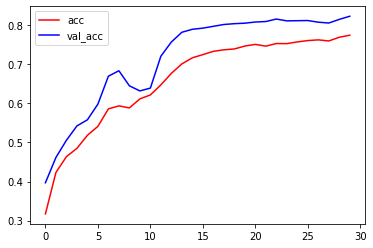

In [18]:
plt.plot(range(model.epochs),model.acc,c='r',label='acc')
plt.plot(range(model.epochs),model.val_acc,c='b',label='val_acc')
plt.legend()
plt.show()

In [19]:
c = 0
for i in range(len(X_test)) :
    print(model.pred_class(X_test[i]),Y_test[i])
    if model.pred_class(X_test[i]) == Y_test[i] :
        c += 1
print(c*100/len(X_test))

1 1
22 22
17 17
22 22
11 11
19 19
8 7
4 15
8 7
2 4
13 13
22 22
4 4
17 17
15 3
0 1
5 5
10 10
18 18
5 15
2 2
10 10
3 3
4 8
22 7
16 11
3 3
19 11
18 8
19 19
5 5
16 16
22 22
4 4
11 16
3 2
5 5
19 18
5 5
2 1
17 17
8 7
19 19
3 3
1 7
14 14
3 3
1 1
0 2
10 9
8 3
22 22
17 17
4 1
4 5
17 17
4 4
19 19
17 17
4 4
2 1
9 9
3 3
1 1
2 10
7 7
0 1
8 8
5 2
1 1
6 6
20 20
19 3
9 9
11 11
2 2
22 22
3 4
6 6
10 11
10 10
2 2
8 7
10 10
3 3
6 6
4 7
1 4
4 4
16 11
9 9
10 10
20 22
16 16
17 17
1 1
4 3
2 2
8 8
4 4
20 20
13 13
11 11
4 1
8 8
20 22
2 2
1 8
22 22
12 11
10 10
4 4
1 1
10 10
2 2
22 22
5 5
2 5
4 4
2 2
4 4
4 5
1 1
9 9
5 5
8 8
20 20
17 17
11 11
17 17
4 12
4 4
16 11
13 13
1 0
18 5
22 8
22 22
2 13
9 9
4 0
20 20
18 18
19 19
19 19
9 9
11 11
1 1
5 5
2 2
11 11
16 11
11 11
18 18
11 11
18 18
23 23
2 1
19 19
11 16
1 1
1 1
17 17
10 10
1 1
20 19
4 5
1 1
17 17
19 19
16 16
5 5
3 2
9 9
2 4
8 3
1 1
2 7
20 22
4 12
22 22
22 22
1 1
5 2
10 10
3 4
8 8
4 4
5 5
6 6
19 19
22 22
8 8
2 2
8 4
11 11
6 3
5 6
1 7
18 18
8 4
11 14
2 2
22 22
22 22

16 16
16 11
10 10
1 1
8 7
15 15
2 1
6 19
4 7
2 5
2 1
4 0
4 1
2 2
11 11
4 4
2 2
8 8
10 10
16 11
23 23
2 5
4 10
2 2
8 8
17 17
17 17
4 15
4 1
4 4
9 9
4 3
14 14
10 10
5 3
16 16
2 2
10 10
20 11
16 11
1 1
2 2
20 22
18 20
2 5
4 7
10 10
4 4
7 6
20 20
16 16
8 7
10 9
9 10
15 13
21 11
5 5
20 20
1 1
19 18
17 17
1 0
1 3
11 11
2 2
16 16
20 22
6 6
19 19
5 5
4 4
8 8
10 10
20 11
1 1
22 22
22 22
5 5
1 1
4 1
3 2
19 19
2 5
1 1
22 22
22 22
4 12
11 13
5 8
22 22
14 14
10 10
20 19
1 1
2 2
5 5
18 18
2 2
2 2
10 10
18 18
2 2
4 8
4 4
22 22
4 4
4 1
17 17
2 2
9 9
19 19
2 5
19 19
10 11
3 3
16 14
22 22
4 23
5 2
16 15
4 15
10 10
20 20
1 1
22 22
1 2
8 8
11 11
4 4
0 7
22 22
9 9
22 22
9 9
4 1
9 9
21 1
1 1
4 7
5 5
13 13
4 4
3 3
8 1
19 19
2 2
14 14
2 2
2 2
4 1
9 9
1 4
2 3
2 5
17 17
22 22
10 10
3 3
4 4
19 8
10 11
22 22
19 19
2 1
10 10
16 16
18 18
4 7
8 8
7 7
10 10
1 3
20 20
7 7
8 8
3 3
5 5
2 2
4 1
5 5
5 5
1 1
7 7
4 1
2 2
8 7
2 1
1 2
2 2
4 4
22 22
16 16
5 6
4 4
15 15
4 4
19 19
7 7
11 15
16 11
1 1
16 15
8 8
4 4
5 7
16 13
1 1


3 3
9 1
8 7
1 9
19 19
2 1
8 8
22 22
2 7
4 2
16 15
3 3
4 1
11 11
3 3
16 11
3 2
4 4
19 19
2 2
12 15
1 8
22 22
8 5
5 5
22 22
2 3
5 3
22 11
14 14
4 4
19 19
4 4
5 5
11 11
22 22
9 9
20 22
22 22
19 19
5 5
20 22
8 5
7 7
16 11
2 1
10 9
4 4
2 1
4 4
4 4
22 22
1 4
2 2
2 2
2 5
17 17
1 1
23 11
1 7
4 4
19 19
5 6
5 5
2 2
1 3
19 19
10 10
4 7
2 2
19 19
4 8
21 22
19 19
1 1
19 19
7 7
2 2
4 0
2 2
4 1
4 4
20 20
8 8
8 7
19 19
1 1
4 4
4 5
7 7
4 3
1 1
1 1
4 12
8 8
4 1
22 22
2 2
2 2
3 7
9 9
23 23
2 3
6 6
10 10
2 2
3 3
10 10
2 2
1 1
4 5
4 8
4 1
19 19
4 0
1 1
1 1
8 2
3 3
18 20
1 4
16 15
5 5
5 5
8 8
8 8
5 5
4 4
2 2
1 4
18 18
11 16
11 11
6 6
7 7
1 1
0 1
4 4
15 15
19 19
4 4
7 7
11 11
16 16
19 19
21 19
4 4
2 2
7 7
22 22
4 20
2 5
19 19
20 20
5 5
21 17
8 8
18 18
2 1
3 3
22 22
10 10
5 6
5 5
5 5
7 7
2 2
8 5
5 3
3 2
15 15
15 13
4 4
14 14
4 4
22 22
5 5
8 8
8 8
2 3
2 5
1 0
5 5
20 20
2 2
16 16
4 10
3 3
2 2
19 22
4 5
2 1
10 10
2 2
2 2
4 10
16 16
22 22
6 6
23 11
5 3
1 1
10 10
11 11
6 6
11 11
5 6
8 8
2 2
20 20
20 20
16 11
8 8
9

17 17
21 11
16 11
22 22
3 2
22 22
15 15
22 22
18 18
22 22
21 4
5 6
4 4
5 5
4 4
22 22
1 1
20 19
1 2
4 1
18 18
4 7
2 2
1 7
5 5
20 19
2 2
13 7
22 22
8 8
10 10
2 5
8 5
8 8
1 1
1 4
6 6
19 19
16 16
11 11
4 2
8 8
3 3
10 10
6 3
2 2
22 22
18 18
4 4
11 16
1 11
5 5
2 1
18 22
9 9
13 15
16 11
4 8
21 17
10 10
4 4
16 16
6 6
18 23
15 15
18 22
20 20
18 19
4 23
3 3
5 3
22 22
10 9
15 15
2 2
4 4
9 9
3 2
2 2
4 4
1 4
8 4
20 20
19 19
2 2
20 20
8 7
1 1
11 11
22 22
22 22
3 3
4 7
14 22
5 6
2 2
10 10
13 8
4 7
11 11
5 3
2 2
17 17
22 22
2 2
1 1
1 2
17 17
22 22
16 16
21 4
5 5
5 5
5 7
17 17
18 18
1 1
5 5
4 4
3 3
21 22
1 2
8 8
8 9
12 12
2 2
5 6
2 2
16 13
4 4
3 3
8 8
15 15
20 20
22 22
2 2
17 17
5 5
4 8
11 11
1 1
22 22
4 12
11 11
9 9
10 10
19 19
5 5
9 9
4 4
17 9
4 15
22 22
5 5
3 3
0 1
1 1
22 22
22 22
16 16
2 2
3 3
5 3
4 7
1 1
4 5
8 8
11 15
21 23
1 1
18 4
1 1
5 5
13 15
1 1
17 17
1 3
4 4
5 5
22 22
14 14
2 3
8 2
5 5
2 4
21 21
16 13
19 19
18 18
11 16
22 22
3 2
2 7
20 11
17 17
1 1
3 3
16 15
2 5
4 4
5 6
2 2
2 3
4 5
1 1
14 11

7 7
23 23
5 3
19 5
15 13
0 0
1 1
6 6
1 4
19 19
19 19
22 22
2 3
5 3
20 20
6 6
10 10
5 7
22 22
19 19
1 0
8 8
8 8
4 1
3 2
10 10
22 22
2 3
4 5
8 4
4 0
2 2
5 8
3 4
4 12
22 11
21 17
1 1
4 0
21 23
8 8
5 5
14 11
5 5
10 10
16 16
17 17
2 2
1 1
1 11
4 4
8 7
22 11
1 1
5 5
0 1
17 17
19 17
5 5
10 10
2 2
22 22
17 17
19 19
4 1
4 4
18 18
2 5
2 2
10 11
21 19
4 0
21 11
2 2
5 5
16 16
14 4
4 8
16 16
1 2
1 3
4 8
9 9
2 7
4 15
8 8
22 22
22 22
10 9
1 1
7 1
13 13
16 16
15 15
8 2
22 22
5 3
13 13
22 22
14 14
5 3
19 19
10 10
21 11
4 4
17 17
10 10
20 20
6 6
3 3
2 5
8 7
4 4
4 4
2 2
22 22
15 13
4 4
8 8
14 14
3 3
3 3
2 8
9 9
4 4
5 7
16 11
11 11
1 1
18 18
19 7
8 4
22 22
5 2
14 14
1 2
8 8
4 8
22 22
20 14
22 22
10 10
10 8
22 22
2 1
4 2
6 6
8 7
16 11
2 3
4 8
10 10
8 8
5 8
4 15
2 2
2 3
2 2
5 5
1 2
3 5
14 14
22 22
11 14
14 14
5 3
14 14
10 9
4 2
9 9
8 7
10 8
16 16
20 1
4 4
7 7
8 8
18 22
10 10
3 7
2 2
4 4
4 23
5 16
20 20
2 1
4 5
22 22
2 2
2 2
1 1
13 13
1 1
3 3
21 21
17 17
4 4
19 19
19 19
5 5
19 19
2 2
11 16
10 10
19 19
11 11


In [20]:
model.pred_class(X_test)

array([ 1, 22, 17, ..., 17,  5,  8], dtype=int64)

In [21]:
model.pred_class(X_train[0])

16

In [22]:
c = 0
for i in range(len(X_train)) :
    #print(model.pred_class(X_train[i]),Y_train[i])
    if model.pred_class(X_train[i]) == Y_train[i] :
        c += 1
print(c*100/len(X_train))

77.95169000380727


[[6.28348962e-18 3.92209075e-20 1.29942620e-10 2.41383729e-12
  9.75755687e-24 3.33674267e-10 4.97665144e-09 2.06078867e-19
  1.95630306e-18 4.28887135e-19 9.46108396e-20 2.66334720e-16
  3.74937398e-15 1.30146223e-08 2.54677413e-09 5.20095020e-10
  6.32404867e-15 6.78200994e-08 4.93283318e-01 7.35818975e-02
  4.23349582e-01 8.86104688e-07 9.78422712e-03 6.42888955e-11]]
Turn left ahead


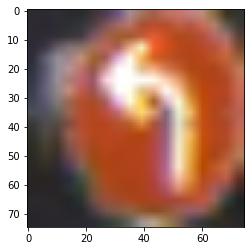

In [23]:
img = X_train[1]
print(model.predict(img))
print(Labels[model.pred_class(img)])
plt.imshow(img)
plt.show()

[[1.00768610e-03 1.12532249e-03 5.10374234e-02 2.76441656e-03
  1.55357921e-03 2.98320057e-02 2.59915456e-03 6.00237455e-03
  3.19538469e-03 9.94321276e-05 2.88234902e-04 6.82508194e-03
  1.34406888e-02 1.02459498e-01 4.22333768e-02 1.68038347e-02
  1.25844833e-02 7.63978352e-03 9.36369979e-02 1.88379996e-01
  4.58066121e-02 3.19191262e-01 3.48990522e-02 1.65943180e-02]]
Go straight or left


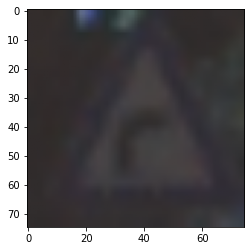

In [24]:
img = X_train[10]
print(model.predict(img))
print(Labels[model.pred_class(img)])
plt.imshow(img)
plt.show()

0.png


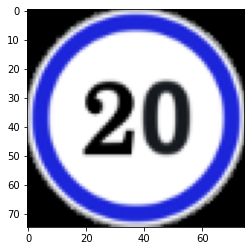

End of speed limit (80km/h)
1.png


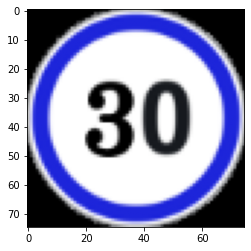

Speed limit (100km/h)
10.png


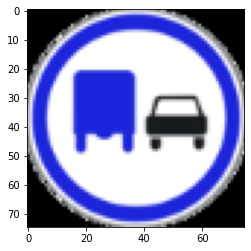

Go straight or left
11.png


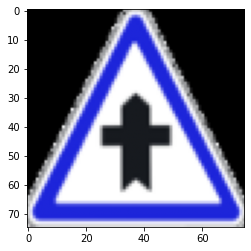

Slippery road
12.png


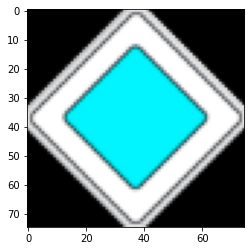

End of speed limit (80km/h)
13.png


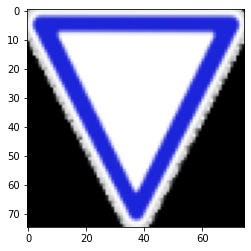

Speed limit (30km/h)
14.png


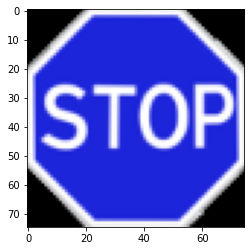

Stop
15.png


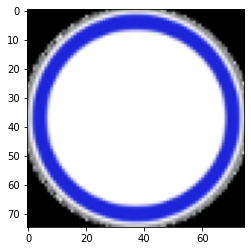

Speed limit (50km/h)
16.png


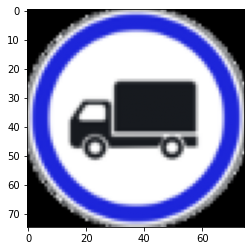

Slippery road
17.png


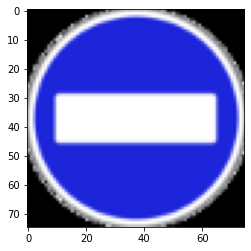

Stop
18.png


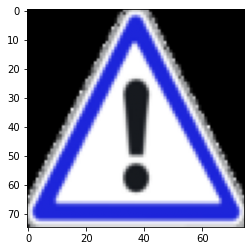

General caution
19.png


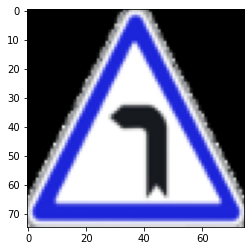

General caution
2.png


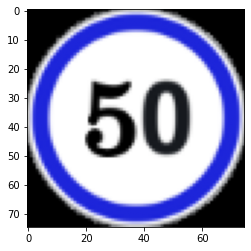

Speed limit (100km/h)
20.png


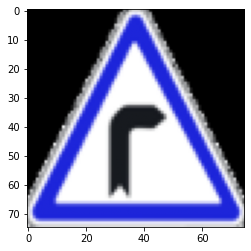

Traffic signals
21.png


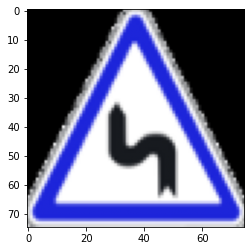

Slippery road
22.png


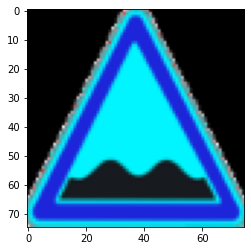

Slippery road
23.png


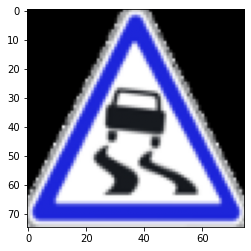

Slippery road
24.png


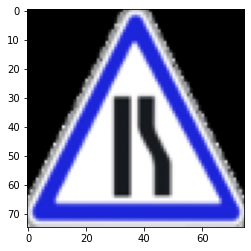

Slippery road
25.png


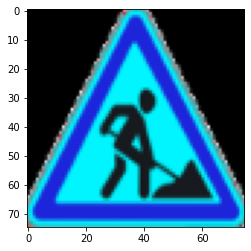

Slippery road
26.png


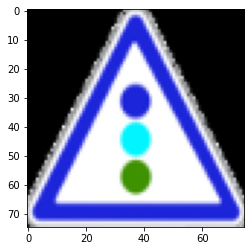

Traffic signals
27.png


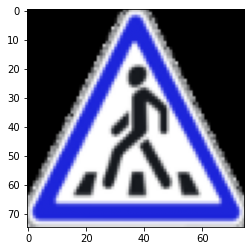

General caution
28.png


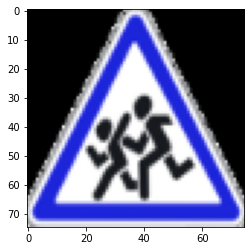

Dangerous curve to the left
29.png


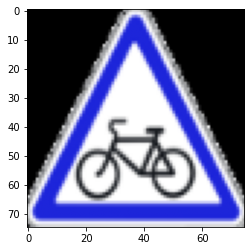

Slippery road
3.png


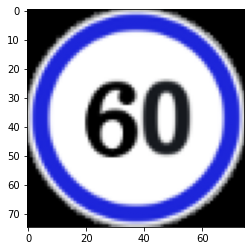

Slippery road
30.png


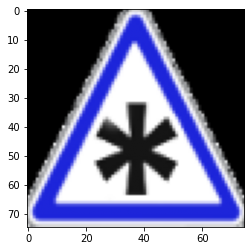

Slippery road
31.png


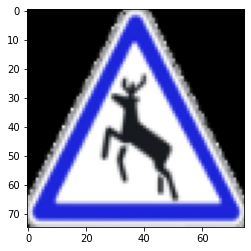

Slippery road
32.png


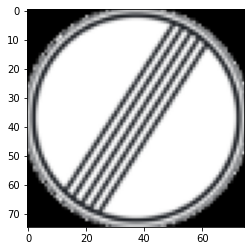

Go straight or right
33.png


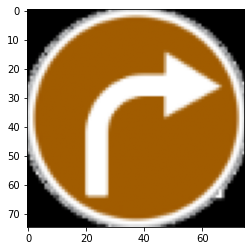

Keep left
34.png


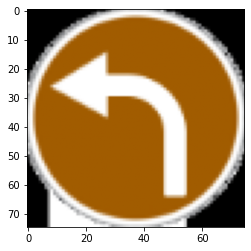

Turn left ahead
35.png


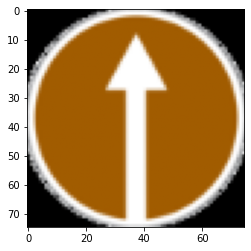

Ahead only
36.png


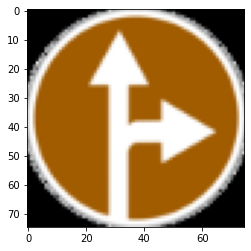

Turn left ahead
37.png


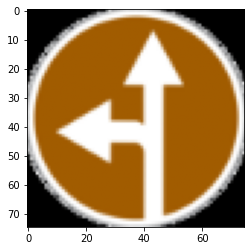

Go straight or left
38.png


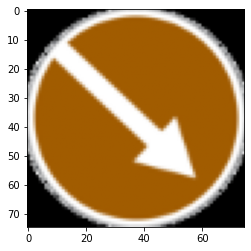

Keep right
39.png


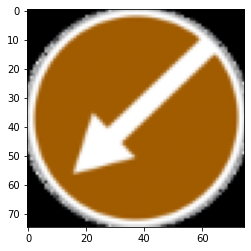

Keep left
4.png


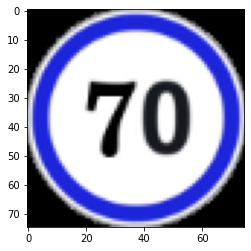

Speed limit (30km/h)
40.png


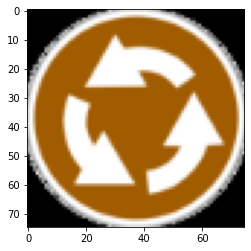

Speed limit (50km/h)
41.png


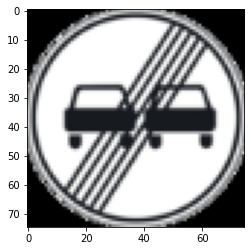

Slippery road
42.png


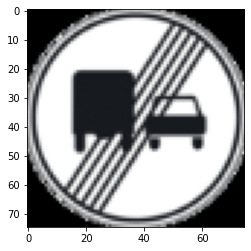

Traffic signals
5.png


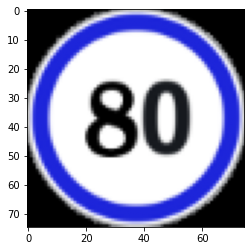

End of speed limit (80km/h)
6.png


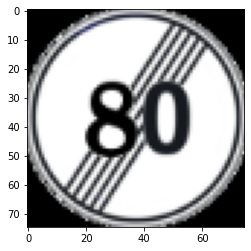

End of speed limit (80km/h)
7.png


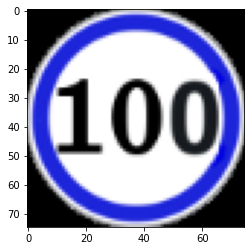

Slippery road
8.png


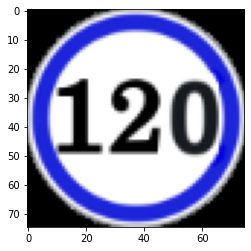

Slippery road
9.png


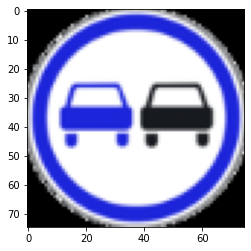

Speed limit (50km/h)


In [26]:
Dir = 'D:/Data/Traffic Signs/Meta'
for i in os.listdir(Dir) :
    print(i)
    img = cv2.imread(Dir+'/'+i)
    img = cv2.resize(img,(size,size))/255.
    test_data = []
    test_data.append(img)
    test_data = np.array(test_data)
    
    plt.imshow(img)
    plt.show()
    
    print(Labels[model.pred_class(test_data)[0]])

In [ ]:
Labels